In [1]:
import logging
from gw_scanner import GravWaveScanner

In [2]:
logger = logging.getLogger("quiet_logger")
logger.setLevel(logging.ERROR)

GravWaveScanner can be initialised with optional arguments *gw_name* and *rev*. By default, it loads the most recent LIGO public event, and the most recent revision.

In [3]:
gw = GravWaveScanner(gw_name="S190728q", logger=logger)

Found voevent S190728q-5-Update.xml
Latest skymap URL: https://gracedb.ligo.org/api/superevents/S190728q/files/LALInference.offline.fits.gz
Saving to: /Users/robertstein/Code/ZTF_ToO_toolkit/LIGO_skymaps/S190728q_5_LALInference.offline.fits.gz
Reading file: /Users/robertstein/Code/ZTF_ToO_toolkit/LIGO_skymaps/S190728q_5_LALInference.offline.fits.gz
MERGER TIME: 2019-07-28T06:45:10.548
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING

Threshold found! 
 To reach 90.00009741504594% of probability, pixels with probability greater than 3.8098001157350675e-06 are included



  2%|▏         | 255527/12582912 [00:00<00:04, 2555266.34it/s]

Threshold found! 
 To reach 90.00009741504594% of probability, pixels with probability greater than 3.8098001157350675e-06 are included
Checking which pixels are within the contour:


100%|██████████| 12582912/12582912 [00:04<00:00, 2927763.95it/s]


Total pixel area: 103.96750030053329 degrees


100%|██████████| 153/153 [00:00<00:00, 91232.37it/s]


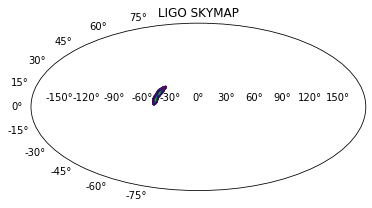

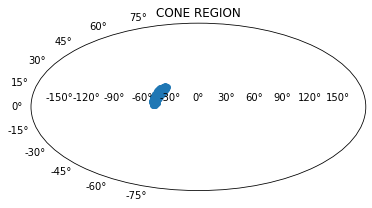

In [4]:
gw.plot_skymap()

In [5]:
gw.scan_cones(max_cones=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Commencing Ampel queries!
Scan radius is 0.9541480607387777
So far, 0 pixels out of 153 have already been scanned.


//anaconda3/envs/ZTF_ToO/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
  0%|          | 0/87 [00:00<?, ?it/s]//anaconda3/envs/ZTF_ToO/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Scanned 20 pixels
Found 87 candidates
Saving to: /Users/robertstein/Code/ZTF_ToO_toolkit/LIGO_candidates/S190728q_5.pdf


100%|██████████| 87/87 [00:23<00:00,  2.15it/s]
